In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import blackjack as b21
import matplotlib.pyplot as plt

from numba import njit, prange

In [3]:
%load_ext autoreload
%autoreload 2 

In [4]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True)

### Analysing play-by-play

In [5]:
# We consider the policy that sticks if the player's sum is 20 or 21
# and sticks otherwise
policy_init = np.zeros((
    b21.PLAY_MAXVAL - b21.PLAY_MINVAL + 1, # Player's value
    2, # has usable ace
    10, # Dealer's one showing card
    2, # hit or stick
))

policy_init[:-2, ..., 1] = 1 # hit for v < 20
policy_init[-2:, ..., 0] = 1 # stick for v >= 20
# policy.shape

### Analysing play-by-play

In [6]:
b21.set_seed(31415)

discount = 1
state_init = b21.init_game()
reward, values, hist = b21.play_single_hist(*state_init, policy=policy_init)

hist_state, hist_action, hist_reward = hist

hist_state

[[12, 0, 6], [21, 0, 6]]

In [7]:
hist_action

[1, 0]

In [8]:
hist_reward

[0, 1]

## Estimating the value function via first-visit MC

In [248]:
@njit(parallel=True)
def first_visit_mc_control(policy_init, n_sims, epsilon, exploring_starts):
    policy = policy_init.copy()
    grid_rewards = np.zeros_like(policy)
    grid_count = np.zeros_like(policy)
    
    hist_rewards = np.zeros(n_sims)
    for s in prange(n_sims):
        hits, _, reward_final = b21.single_first_visit_mc(policy, exploring_starts)
        for element in hits:
            ixs, sim_reward, action = element
            ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs
            if (ix_value_cards + b21.PLAY_MINVAL) > 21:
                continue
                        
            ix_update = ix_value_cards, ix_has_usable_ace, ix_dealers_card, action
            ix_eval = ix_value_cards, ix_has_usable_ace, ix_dealers_card
                        
            grid_rewards[ix_update] += sim_reward
            grid_count[ix_update] += 1
            
            # Improvement
            expected_return = grid_rewards[ix_eval] / np.maximum(grid_count[ix_eval], 1)
            
            n_actions = len(expected_return)
            new_action = expected_return.argmax()
            
            ix_improve = *ix_eval, new_action            
            policy[ix_eval] = epsilon / n_actions
            policy[ix_improve] = 1 - epsilon + epsilon / n_actions
            
        hist_rewards[s] = reward_final
            
    
    return grid_rewards, grid_count, policy, hist_rewards

In [249]:
range_value_cards = np.arange(b21.PLAY_MINVAL, b21.PLAY_MAXVAL + 1)
range_dealers_card = np.arange(1, 11)

In [250]:
# We consider the policy that sticks if the player's sum is 20 or 21
# and sticks otherwise
policy_init_shape = (
    b21.PLAY_MAXVAL - b21.PLAY_MINVAL + 1, # Player's value
    2, # has usable ace
    10, # Dealer's one showing card
    2, # hit or stick
)
policy_init = np.zeros(policy_init_shape, dtype=np.float32)

epsilon = 0.01
n_actions = 2

policy_init[:-1, ..., 1] = 1 - epsilon + epsilon / n_actions # hit for v < 20
policy_init[:-1, ..., 0] = epsilon / n_actions


policy_init[-1:, ..., 0] = 1 - epsilon + epsilon / n_actions # stick for v >= 20
policy_init[-1:, ..., 1] = epsilon / n_actions

# policy.shape

In [239]:
%%time
b21.set_seed(3141)
n_sims = 50_000_000
exploring_starts = True
res = first_visit_mc_control(policy_init, n_sims, epsilon, exploring_starts)
grid_rewards, grid_count, policy_final, hist_rewards = res

CPU times: user 3min 32s, sys: 370 ms, total: 3min 32s
Wall time: 2.75 s


In [240]:
hist_rewards[10_000:].mean()

0.03742996599319864

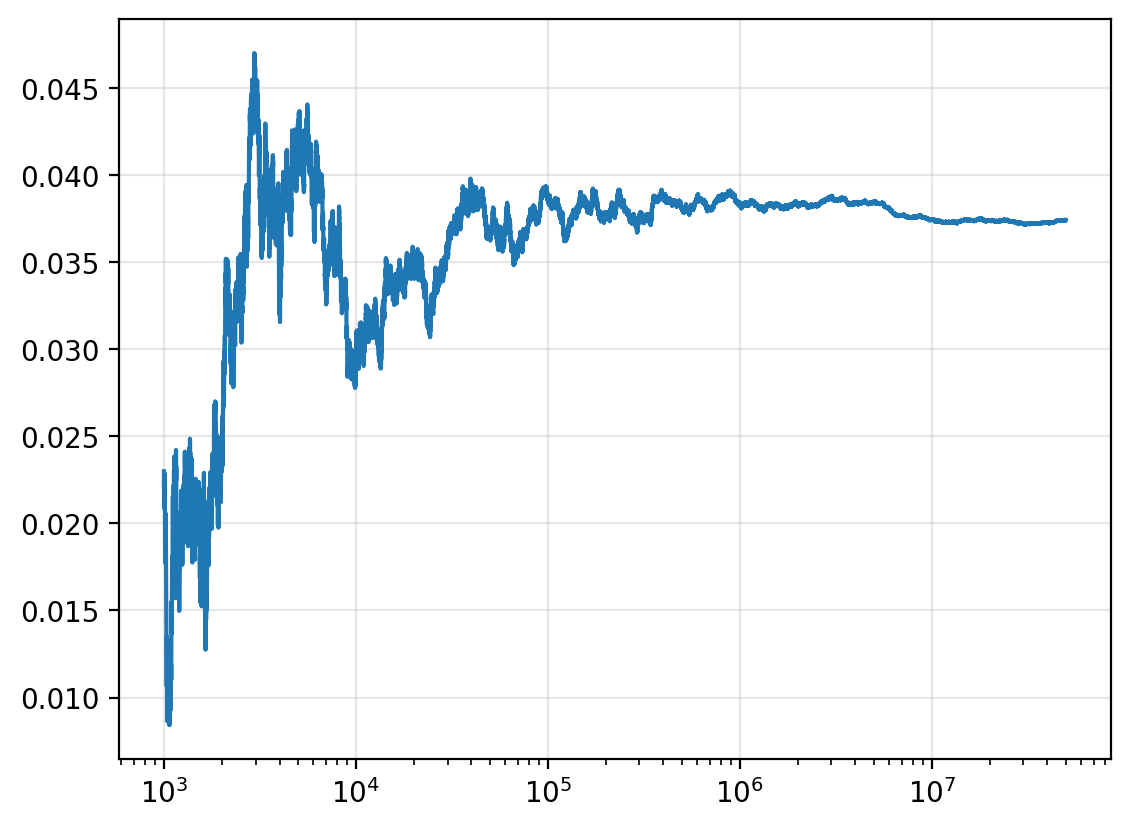

In [241]:
pd.Series(hist_rewards[100_000:]).expanding(1_000).mean().plot()
plt.xscale("log")
# plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

/tmp/ipykernel_1145015/2400018542.py:4: RuntimeWarning: invalid value encountered in divide
  rw = grid_rewards / grid_count


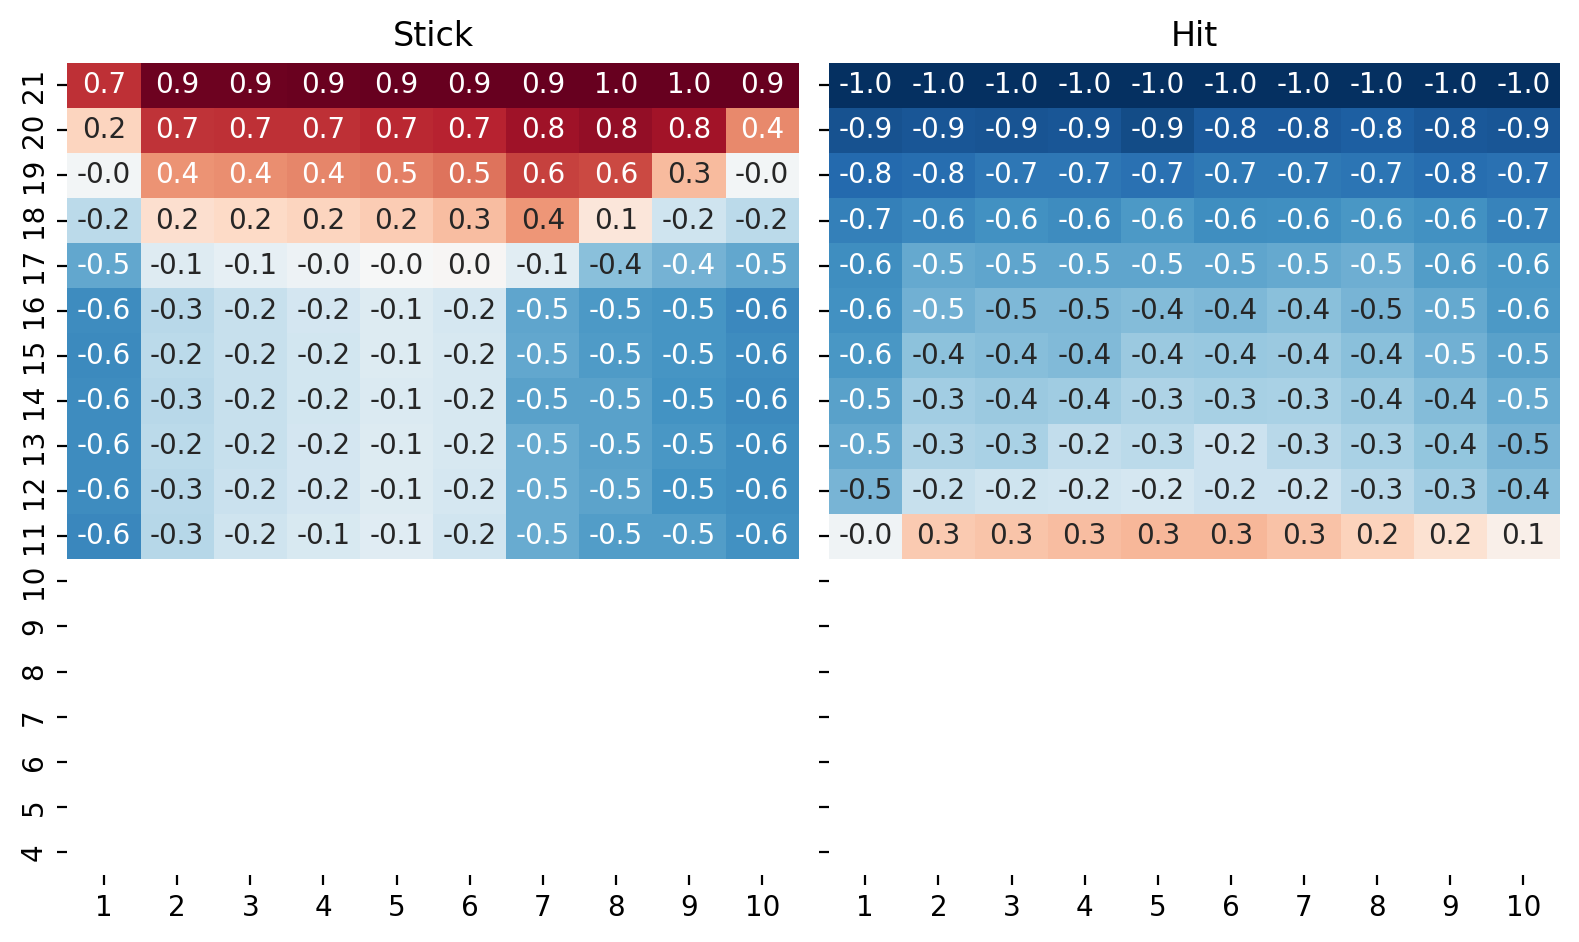

In [242]:
axis_value = np.arange(b21.PLAY_MINVAL, b21.PLAY_MAXVAL + 1)
column_value = np.arange(1, 11)

rw = grid_rewards / grid_count
hua = 0 # has usable ace
vf_stick = pd.DataFrame(rw[:, hua, :, 0], index=axis_value, columns=column_value)
vf_hit = pd.DataFrame(rw[:, hua, :, 1], index=axis_value, columns=column_value)

fig, ax = plt.subplots(1, 2, figsize=(8, 4.8), sharey=True)
sns.heatmap(
    vf_stick, annot=True, fmt="0.1f", ax=ax[0], vmin=-0.6, vmax=0.92, cbar=False, cmap="RdBu_r", center=0.0,
    yticklabels=axis_value
)
sns.heatmap(
    vf_hit,
    annot=True, fmt="0.1f", ax=ax[1], cbar=False, cmap="RdBu_r", center=0.0
)
ax[0].set_title("Stick")
ax[1].set_title("Hit")
ax[0].invert_yaxis()
plt.tight_layout()

In [243]:
policy_final_ace = pd.DataFrame(
    policy_final[:, 1, :, 1],
    index=range_value_cards,
    columns=range_dealers_card
)

policy_final_no_ace = pd.DataFrame(
    policy_final[:, 0, :, 1],
    index=range_value_cards,
    columns=range_dealers_card
)

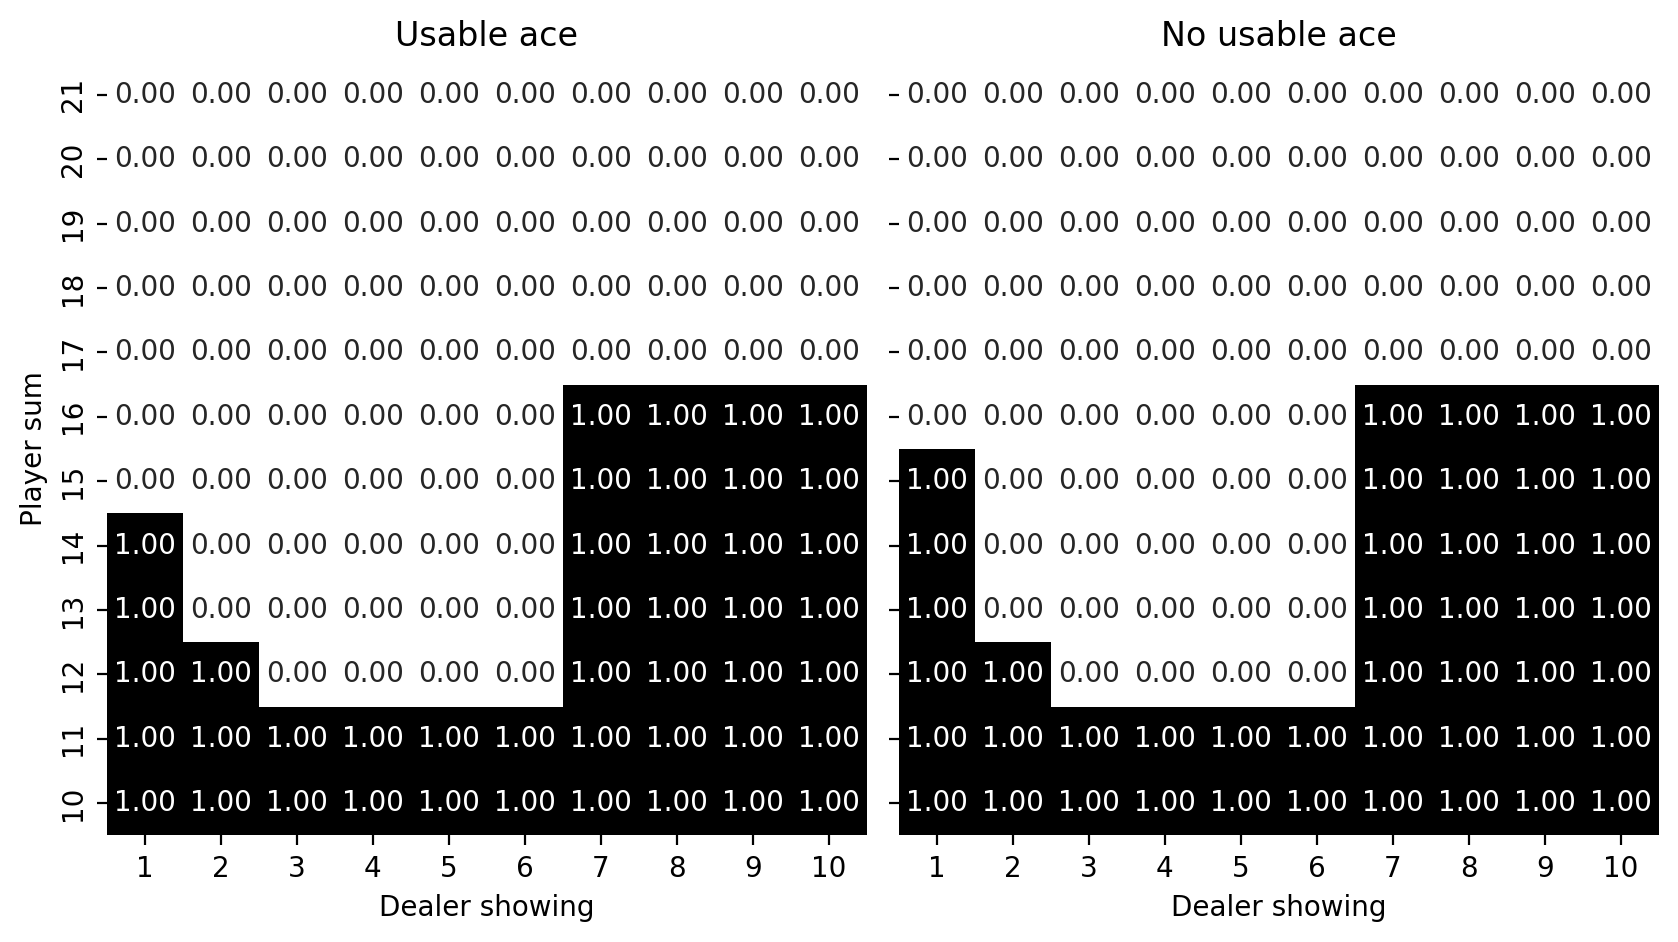

In [244]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4.8), sharey=True)

sns.heatmap(policy_final_ace.loc[10:], cmap="bone_r", annot=True, ax=ax[0], cbar=False, fmt="0.2f")
sns.heatmap(policy_final_no_ace.loc[10:], cmap="bone_r", annot=True, ax=ax[1], cbar=False, fmt="0.2f")
ax[1].invert_yaxis()

ax[1].set_xlabel("Dealer showing")
ax[0].set_xlabel("Dealer showing")
ax[0].set_ylabel("Player sum")

ax[0].set_title("Usable ace")
ax[1].set_title("No usable ace")

plt.tight_layout()

## Eval

In [245]:
%%time
grid_rewards, grid_count = b21.first_visit_mc_eval(policy_final, 5_000_000, exploring_starts=True)

grid_value_function = grid_rewards / grid_count

vf_no_ace = grid_value_function[:, 0, :]
vf_no_ace = pd.DataFrame(vf_no_ace, index=range_value_cards, columns=range_dealers_card)

vf_ace = grid_value_function[:, 1, :]
vf_ace = pd.DataFrame(vf_ace, index=range_value_cards, columns=range_dealers_card)

CPU times: user 15.5 s, sys: 20.9 ms, total: 15.5 s
Wall time: 216 ms


<timed exec>:3: RuntimeWarning: invalid value encountered in divide


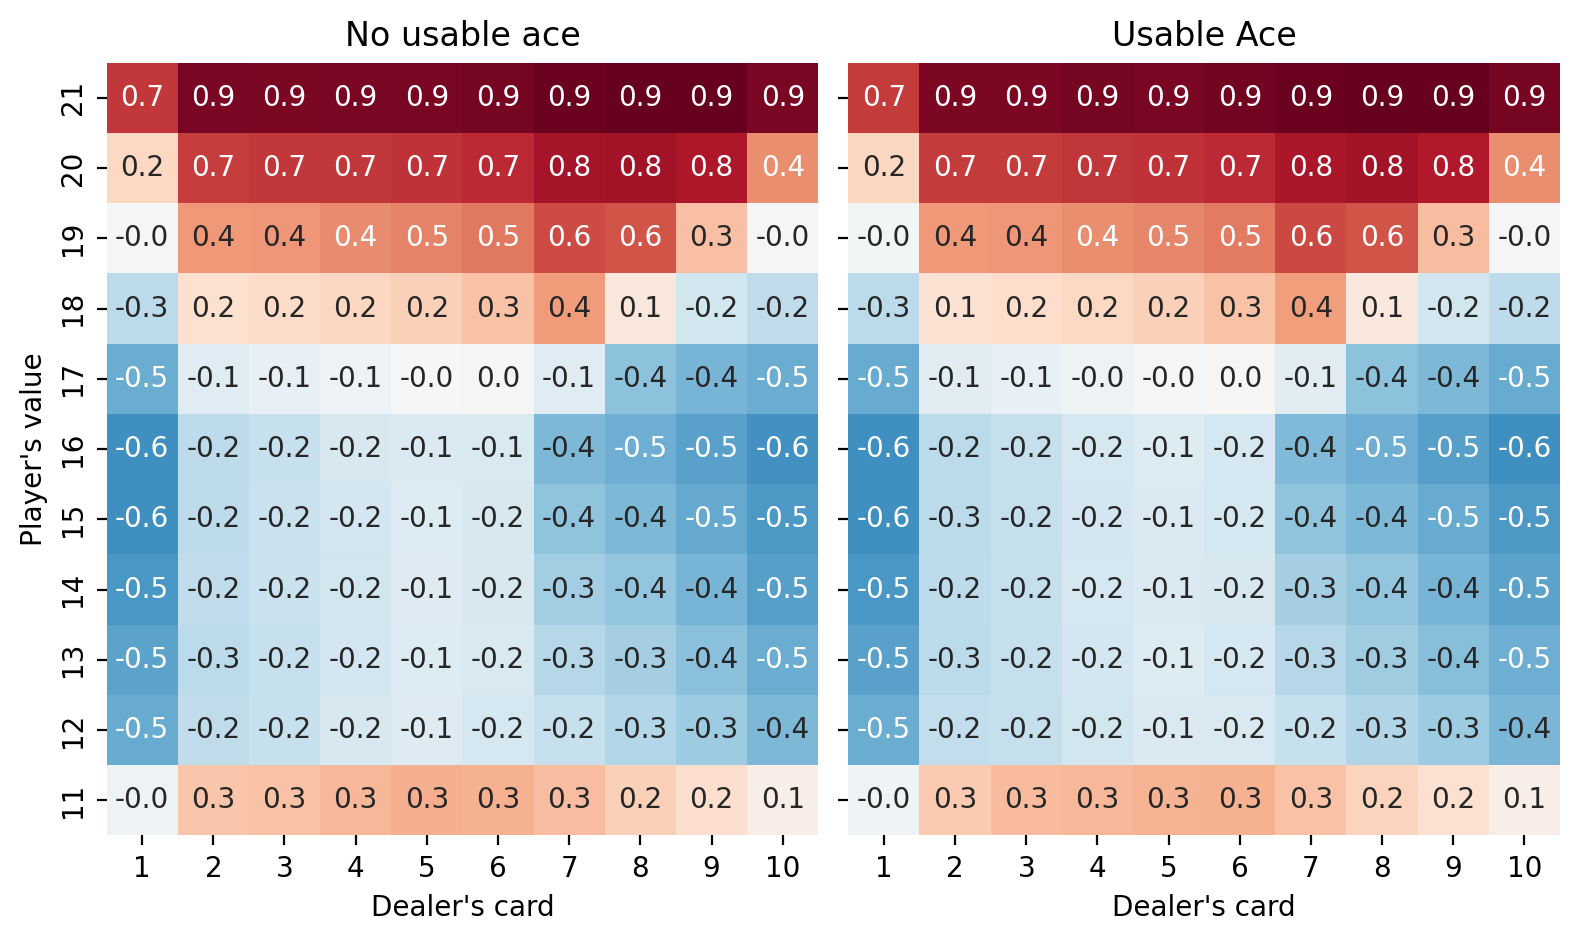

In [246]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4.8), sharey=True)
for axi, vf in zip(ax, [vf_ace.loc[11:], vf_no_ace.loc[11:]]):
    sns.heatmap(vf, cmap="RdBu_r", ax=axi, annot=True, fmt="0.1f", center=0.0, cbar=False)
    axi.set_xlabel("Dealer's card")

ax[0].set_ylabel("Player's value")
ax[0].set_title("No usable ace")
ax[1].set_title("Usable Ace")
ax[0].invert_yaxis()
plt.tight_layout()

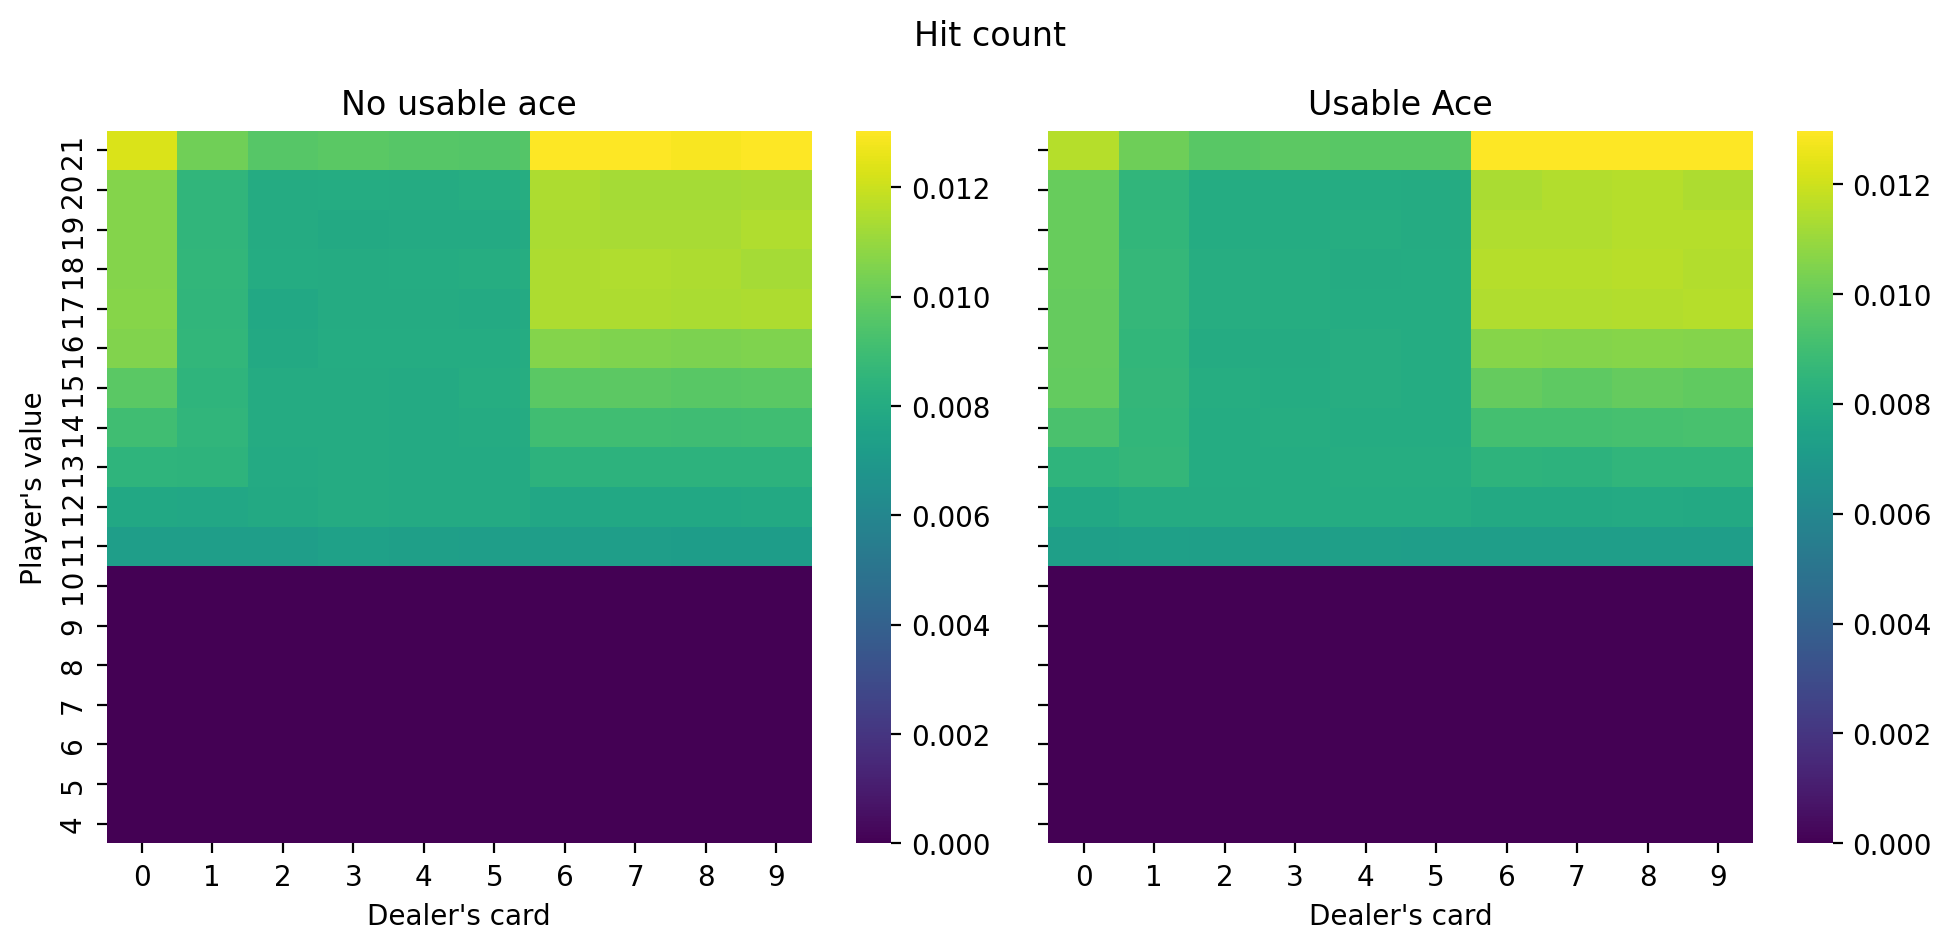

In [247]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.8), sharey=True)

for i, axi in enumerate(ax):
    p_grid = grid_count[:, i, :]
    p_grid = p_grid / p_grid.sum()
    vf = pd.DataFrame(p_grid, index=range_value_cards, )
    sns.heatmap(vf, cmap="viridis", ax=axi)
    axi.set_xlabel("Dealer's card")

ax[0].set_ylabel("Player's value")
ax[0].set_title("No usable ace")
ax[1].set_title("Usable Ace")
ax[0].invert_yaxis()
plt.suptitle("Hit count")
plt.tight_layout()